In [5]:
!python3 -m pip install --upgrade pip

In [6]:
!pip install torch torchvision 
!pip install opencv-python scipy matplotlib 
!pip install scikit-image scikit-learn pandas jupyterlab numpy

In [225]:
import torch
torch.__version__

'2.2.1'

In [226]:
device = 'cpu'

In [227]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
from torch.optim import Adam
import math

In [228]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t) # x_0 + noise = x_noisy 
    noise_pred = model(x_noisy, t) # x_noisy ---> noise
    return F.l1_loss(noise, noise_pred)

In [229]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if (t==0):
        return model_mean

    else:

        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

In [230]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

In [231]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if (t==0):
        return model_mean

    else:

        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

In [232]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [233]:
def forward_diffusion_sample(x_0, t):
    """
    Takes an image x_0 and a timestep t as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [234]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding='same')
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding='same')
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 1, padding='same')
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [235]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

In [236]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (32,32,32)
        up_channels = (32,32,32)
        out_dim = 1
        time_emb_dim = 32
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], image_channels, padding='same')
        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

## Train

In [243]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
batch_size = 2000
num_epochs = 10
lamda_reg =0.2
wavenum_init=10
wavenum_init_ydir=10
T = 300 #diffusion iteration
lr=0.005

In [244]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
print(model)
optimizer = Adam(model.parameters(), lr=lr)

Num params:  131201
SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (downs): ModuleList(
    (0-1): 2 x Block(
      (time_mlp): Linear(in_features=32, out_features=32, bias=True)
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (transform): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (ups): ModuleList(
    (0-1): 2 x Block(
      (time_mlp): Linear(in_features=32, out_features=32, bias=True)
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride

## Dataset load

In [245]:
import tensorflow as tf
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [246]:
train = list(train_dataset)

2024-04-11 05:55:07.775982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [247]:
len(train), np.shape(train[0])

(30, TensorShape([2000, 28, 28, 1]))

In [248]:
for epoch in range(0, num_epochs):  # loop over the dataset multiple times
    running_loss = 0
    step = 0
    for step in range(0, len(train)):
        input_data = train[step]
        input_data = torch.permute(torch.from_numpy(input_data.numpy()),[0,3,1,2])
        indices = np.random.permutation(np.arange(start=0, stop=batch_size)) #manual batch norm
        input_data = input_data[indices, :, : ,: ]
        # zero the parameter gradients
        optimizer.zero_grad()
        t = torch.randint(0, T, (batch_size,)).long()
        loss = get_loss(model, input_data, t)
        loss.backward()
        optimizer.step()
        running_loss = loss
        print('step',step,'Epoch',epoch,'Loss',loss)
    print('Epoch',epoch,'Average Loss',running_loss/float(step+1))
torch.save(model.state_dict(), './Diffusion_Mnist.pt')
print('Model saved')

step 0 Epoch 0 Loss tensor(0.8238, grad_fn=<MeanBackward0>)
step 1 Epoch 0 Loss tensor(0.7718, grad_fn=<MeanBackward0>)
step 2 Epoch 0 Loss tensor(0.6639, grad_fn=<MeanBackward0>)
step 3 Epoch 0 Loss tensor(0.5618, grad_fn=<MeanBackward0>)
step 4 Epoch 0 Loss tensor(0.5027, grad_fn=<MeanBackward0>)
step 5 Epoch 0 Loss tensor(0.5058, grad_fn=<MeanBackward0>)
step 6 Epoch 0 Loss tensor(0.4638, grad_fn=<MeanBackward0>)
step 7 Epoch 0 Loss tensor(0.4387, grad_fn=<MeanBackward0>)
step 8 Epoch 0 Loss tensor(0.4221, grad_fn=<MeanBackward0>)
step 9 Epoch 0 Loss tensor(0.4112, grad_fn=<MeanBackward0>)
step 10 Epoch 0 Loss tensor(0.3989, grad_fn=<MeanBackward0>)
step 11 Epoch 0 Loss tensor(0.3862, grad_fn=<MeanBackward0>)
step 12 Epoch 0 Loss tensor(0.3720, grad_fn=<MeanBackward0>)
step 13 Epoch 0 Loss tensor(0.3615, grad_fn=<MeanBackward0>)
step 14 Epoch 0 Loss tensor(0.3538, grad_fn=<MeanBackward0>)
step 15 Epoch 0 Loss tensor(0.3537, grad_fn=<MeanBackward0>)
step 16 Epoch 0 Loss tensor(0.3424

In [261]:
tt =  torch.randint(0, T, (1,), device=device).long() 
for dataset in train_dataset:
    x = torch.permute(torch.from_numpy(dataset.numpy()),[0,3,1,2])
    print(x.size())
    break
x_noisy, noise = forward_diffusion_sample(x[0].reshape([1,1,28,28]).float(), tt)
u=x_noisy - model(x_noisy, tt) 
pred = u.detach().numpy()
print(np.shape(pred[0,0]))

torch.Size([2000, 1, 28, 28])
(28, 28)


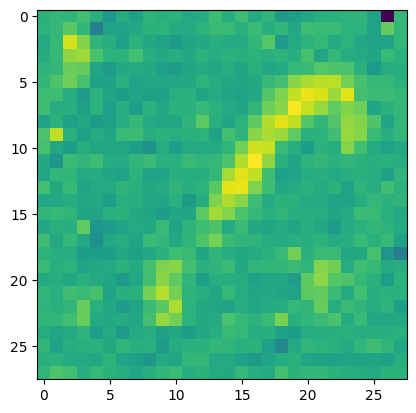

In [262]:
import matplotlib.pyplot as plt

plt.imshow(pred[0,0,:,:])